<a href="https://colab.research.google.com/github/dindong16/tugas_dl/blob/main/dindong16/tugas_dl/TugasDLTM4/batchsize32danlearningrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hummingbirds-at-my-feeders:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F714100%2F1263556%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T045324Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D01cd0278a547a2783615161c47d225b4c713b9afa5fa8abedfa7c5358cf9a3df3f8bb058cc7bfef3245f533ecd7051e7120c1b569476b65061435aa01f66cd47d496d35227796f8a54d0ee7b9ede55293e1469a04dfb96a9599279aa50e5f50fc08331da8c5d45ea99e365374e3e2a8c4efb4f9129a49289d51fc202e04c8bc9152d72694dc03391b30a949b1ab8ad9c093f1efbfa36013ebe28b4621c255d1ab3c735621b7d8ed379f88f9a01c92338d81acb6b9d3a414fc3d2060dc57f6ec20aab1c0d4006343b42e27d6d1a54060f7850ad5eabae9e11e4eeb42bddda6b4f2d98843ff0c44453275ee10882a50eed7a2514cd3ece5d59aa3ee037241a3d5d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20500243 bytes downloaded
Downloaded and uncompressed: hummingbirds-at-my-feeders
Data source import complete.


In [4]:
''' Global Configuration Settings '''
class CFG:

    def __init__(self):
        self.labels = 4
        self.sshape = (100,100,3) # Increasable to 224
        self.n_epochs = 50
        self.seed = 221

cfg = CFG()

In [5]:
import os
import numpy as np
import random as rn
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from PIL import Image
%matplotlib inline
import time

from keras import models
import tensorflow as tf
from tensorflow.keras import applications as app
from tensorflow.keras.models import Sequential # Sequential model initialization
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data pipeline building
from functools import partial
import keras
from keras import backend as K

# various library seeds
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(cfg.seed)
rn.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

# Palettes
lst_color = ['#B1D784','#2E8486','#004379','#032B52','#EAEA8A']

''' Folder Pathways'''
main_folder = '/kaggle/input/hummingbirds-at-my-feeders/'
train_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train/'
val_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/valid/'
test_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/test/'
video_folder = '/kaggle/input/hummingbirds-at-my-feeders/video_test/'

![](https://i.imgur.com/icqghBp.png)
**For [Hummingbirds at my feeders](https://www.kaggle.com/akimball002/hummingbirds-at-my-feeders) dataset, Wonderful Photo by [Zdeněk Macháček](https://unsplash.com/@zmachacek)**

# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>1 |</span></b> Introduction</div>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>1.1 |</span></b> Problem Statement</b></p>
</div>

#### **<span style='color:#B6DA32'>TYPES OF BIRD MONITORING</span>**

- There are two main types of possible bird monitoring approaches that exist to this day:
> We can either see a bird (**<span style='color:#B6DA32'>visual monitoring</span>**) or we can hear it (**<span style='color:#B6DA32'>sound based monitoring</span>**).
- Both approaches have specific challenges, & in both cases, **<span style='color:#B6DA32'>expert identification</span>** tends to be required to identify a specie correctly.
- To this day, a sizable portion of the **<span style='color:#B6DA32'>monitoring</span>** & **<span style='color:#B6DA32'>observation</span>** surrounding birds is mostly **<span style='color:#B6DA32'>done manually</span>** by researchers & bird monitoring enthusiasts.

Just to note a few collaboration efforts:

> I. For example; you can submit your own sightings to [Hummingbirdcentral](https://www.hummingbirdcentral.com/) <br>
> II. Another example; for bird sound based sighting; [Xeno-Canto](https://www.xeno-canto.org/).

#### **<span style='color:#B6DA32'>ANYONE CAN CONTRIBUTE</span>**

- Various people from different backgrounds and level of bird knowledge & bird monitoring can contribute to such a wonderful cause:

> I. Conservation organizations would also have better information on migratory and breeding patterns</b> <br>
> II. This knowledge can be used to determine if specific changes in the environment or ecology has positively or negatively impacted bird life. <br>

#### **<span style='color:#B6DA32'>SOME OF THE ISSUES</span>**

- Such contributions often requiring only field notes and reasoning, with optional photographic evidence, which is an indication that sampled data could potentially be incorrect due to the inexperienced contributors.
- Visual monitoring requires **<span style='color:#B6DA32'>constant expert confirmation</span>** in order for the data to be of significant use.
- <b>Visual monitoring</b> is definitely by far quite the more popular approach for monitoring birds.
- People who are interested in birds often end up deciding to help, turning to quite affordable photography/video gear, even smartphones, which these day have the capability to help bird monitoring.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>1.2 |</span></b> Some of the challenges</b></p>
</div>

- With the increased affordability of visual monitoring equipment, it has become practical for anyone to contribute to such a wonderful cause & help make each sighting more valid.

#### **<span style='color:#B6DA32'>ARISING INCONSISTENCIES</span>**

- Often, due to <b>limitations of gear</b>, <b>poor photography/videography technique</b>, or **<span style='color:#B6DA32'>simply poor lighting conditions</span>**, it can be difficult for users, <b>let alone experts</b> to distinguish what specific bird was seen at the time of monitoring.

#### **<span style='color:#B6DA32'>DATASET WITH VISUALLY SIMILAR SPECIES</span>**

- In this study, we will focus our attention to a bird called the <b>hummingbird</b>. What is useful about this specie is that, despite being quite distinguishible in shape, <b>they have a variery of unique colouring</b>, which means that if images are of poor quality, it may be hard for humans or models to distinguish them.

#### **<span style='color:#B6DA32'>USING MODELS TO HELP IDENTIFY SPECIES</span>**

- In the entire process of <b>expert identification</b> & dealing with various image related inconsistencies outlied previously, manual identification for monitoring can be quite labourous, so an automated system of identification can go a long way.
- In our quest to create an automated approach, we can be left with a collection or under or over exposed images that will create difficulties for the model to distinguish between different classes correctly.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>1.3 |</span></b> Notebook Aim</b></p>
</div>

The ultimate goal is to have a **<span style='color:#B6DA32'>classification system</span>** that can address such the above stated varieties in an image & **<span style='color:#B6DA32'>correctly distinguish very similar bird species</span>**.

# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>2 |</span></b> The Dataset</div>

- We will go through the images images used in training and attempt to outline some key things we can observe.
- The primary birds at the feeder are [broad-tailed (Selasphorous platycerus)](https://www.allaboutbirds.org/guide/Broad-tailed_Hummingbird/id ) and [rufous (Selasphorous rufus)](https://www.allaboutbirds.org/guide/Rufous_Hummingbird/) hummingbirds.

#### **<span style='color:#B6DA32'>FOLDER LAYOUT</span>**
- We have a specific folder already assembled specifically for modelling; <b>hummingbirds</b>, which contains subfolders for each separate class. When it comes time to create a dataset, this will be very convenient since we can just call the <b>.flow_from_directory</b> function.
- There also is a folder containing a 'no bird' classification.
- As well as two other folder associated with a video recording (collection of still images); <b>video_test</b> & All images in the dataset; <b>All_images</b>

In [6]:
os.listdir(main_folder)

['video_test', 'All_images', 'hummingbirds']

In [7]:
os.listdir(train_folder)

['No_bird', 'Broadtailed_female', 'Broadtailed_male', 'Rufous_female']

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>2.1 |</span></b> Training image exploration</b></p>
</div>

Let's view what kind of images we are dealing with in this dataset.

In [8]:
''' Visualise Image Data '''
def show_grid(image_list,nrows,ncols,label_list=None,
              show_labels=False,savename=None,
              figsize=(20,10),showaxis='off'):

    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True)

    for i in range(nrows*ncols):
        ax = grid[i]
        img = Image.open(image_list[i])
        ax.imshow(img,cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis(showaxis)
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

In [9]:
lst_temp = os.listdir(train_folder+'/Rufous_female')
lst_rufous_female = []
for i in lst_temp:
    lst_rufous_female.append(train_folder+'/Rufous_female/'+i)

lst_temp = os.listdir(train_folder+'/Broadtailed_female')
lst_broad_female = []
for i in lst_temp:
    lst_broad_female.append(train_folder+'/Broadtailed_female/'+i)

lst_temp = os.listdir(train_folder+'/Broadtailed_male')
lst_broad_male = []
for i in lst_temp:
    lst_broad_male.append(train_folder+'/Broadtailed_male/'+i)

lst_temp = os.listdir(train_folder+'/No_bird')
lst_none = []
for i in lst_temp:
    lst_none.append(train_folder+'/No_bird/'+i)

#### **<span style='color:#B6DA32'>RUFOUS FEMALE</span>**
- The addition of the <b>female as opposed to the male</b> is an interesting choice for the dataset, making it indeed very challenging for the model, due to the high similarity of different species' image values. The female, unlike the male is very similar to the <b>broadtail female</b>, <b>especially when in the shade</b>, we actually have quite a few such cases, as seen in the images below.
- However we can notice that in all images, colours of the back/rump are <b>quite dull, more saturated, but with hints of green</b>, just enough to be able to make out the green colour.
- We can also note that the images have quite a <b>bit of "noise"</b>, that could potentally affect the accuracy of the model; <b>the feeder & the flag introduce red values into the images</b>, which can affect the model accuracy.

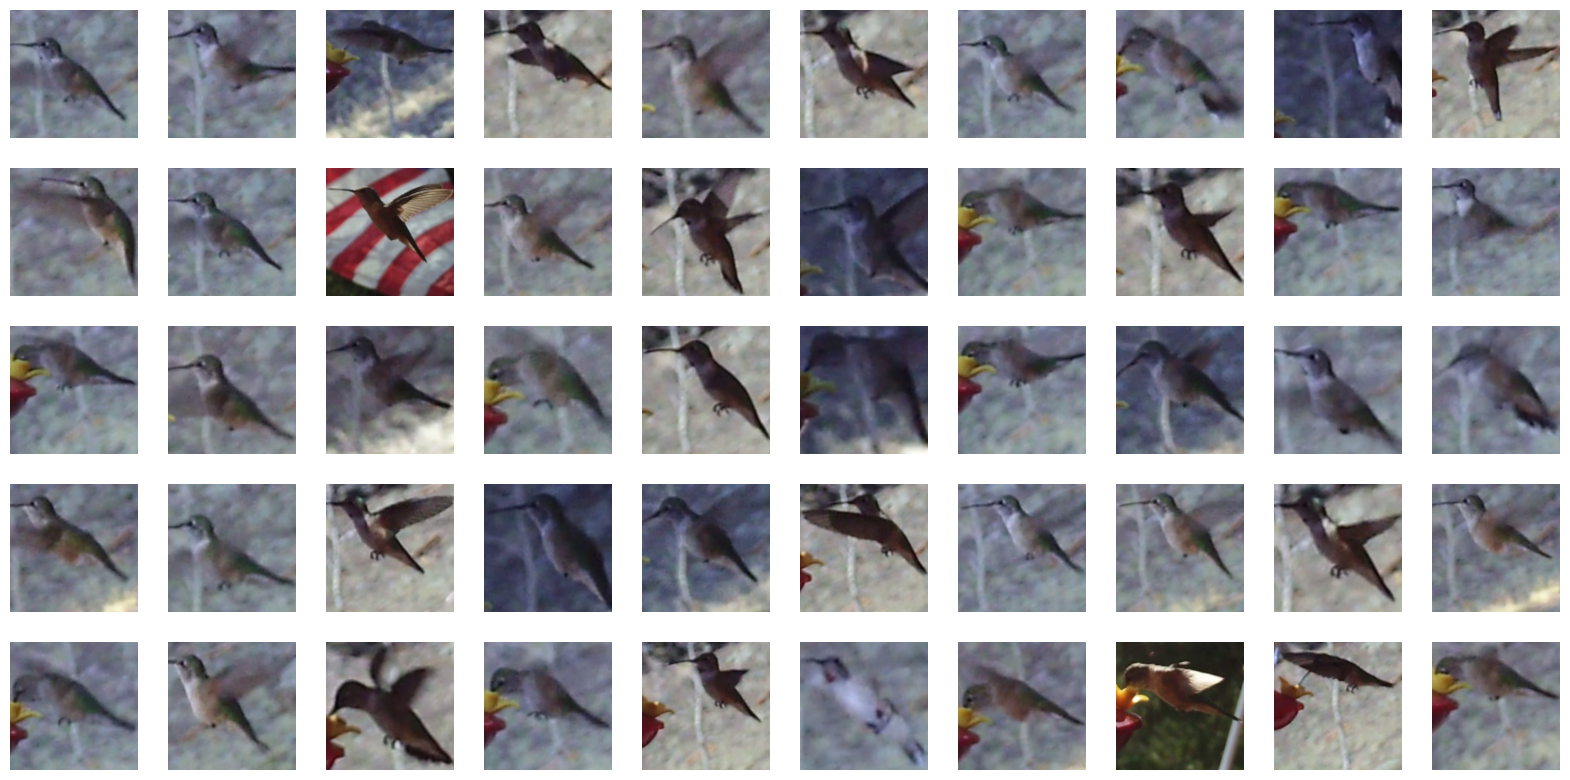

In [10]:
show_grid(lst_rufous_female,5,10,figsize=(20,10))

#### **<span style='color:#B6DA32'>BROADTAIL FEMALE</span>**
- To the naked eye, there is <b>a lot of similarities</b> between the <b>Rufous</b> & <b>Broadtail Females</b>.
- Without adequate lighting and refence to multiple frames (such as from a video), one could easily mislabel the species.
- The boadtail female colour definitely stand out more, the two species so far have very similar bagrounds & the ocassional feeder.

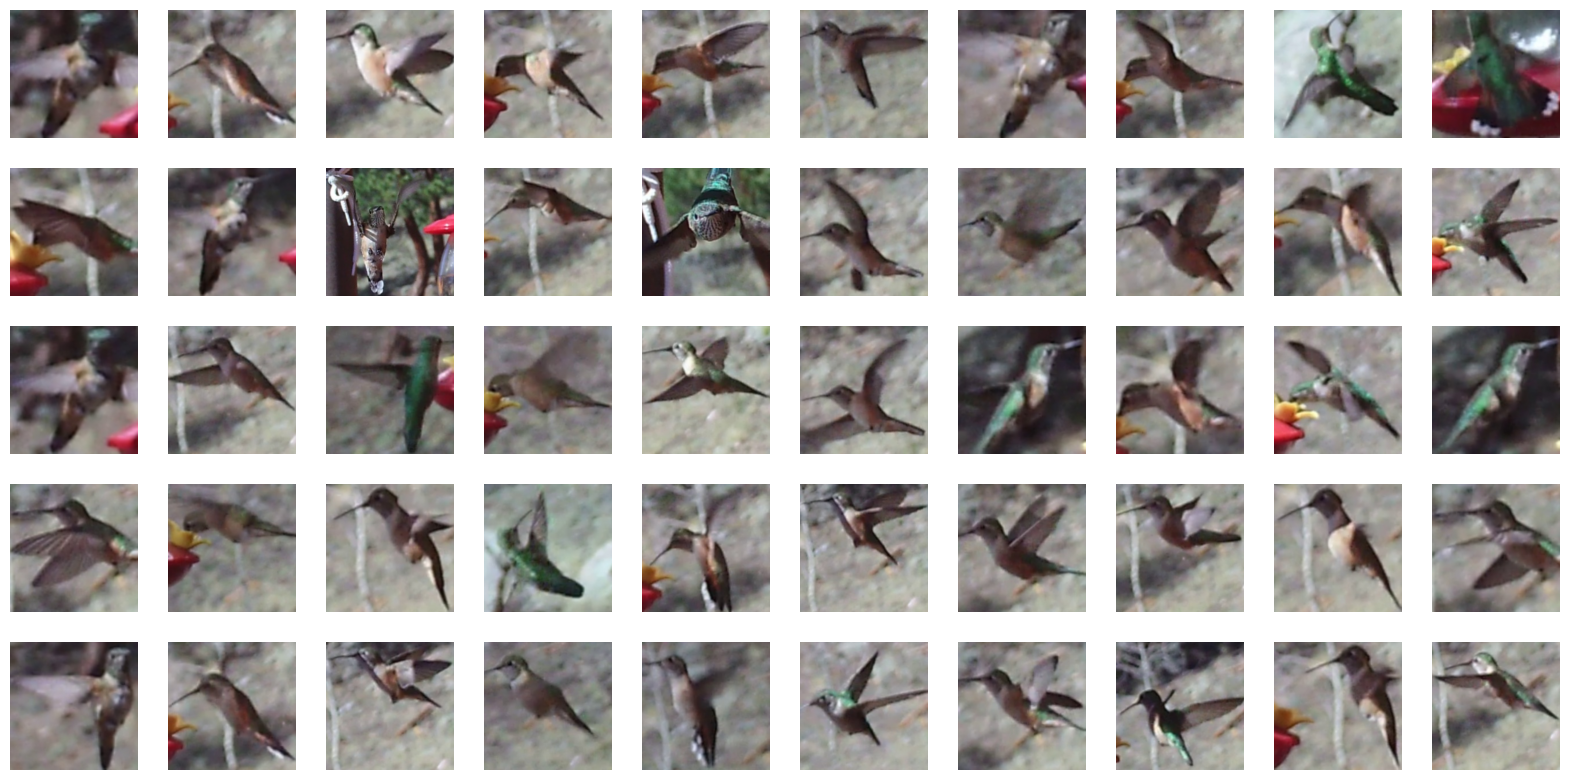

In [11]:
show_grid(lst_broad_female,5,10,figsize=(20,10))

#### **<span style='color:#B6DA32'>BROADTAIL MALE</span>**
- Like the adult female, the males also have green and buffy flanks.
- What separates the male broadtail from the female and even from the Rufous female is the **distinctive rose/magenta throats**.
- It's quite likely the model would be easily able to classify any image containing the male from the rest, if the feeder or flag wasn't of similar color.
- We can clearly observe that the feeder, has both darker spots and lighter spots, lighter spots have values very similar values to the throat.
- We can also note some images don't visibly have this distinctive red colour throat (at least to the naked eye), one possible reason being that the bird is <b>in the shade at the time of capture</b>. It's also possible that the images are not correctly labeled, which cannot also be ruled out. However we can clearly note that the model will need to adapt to images <b>taken under direct sunlight</b> and <b>different shade variations</b>, which create some problematic scenarios.
- And <b>last but not least</b>, we can't rule out <b>immature males</b> from the pack as well. They are extremly similar to female as well.

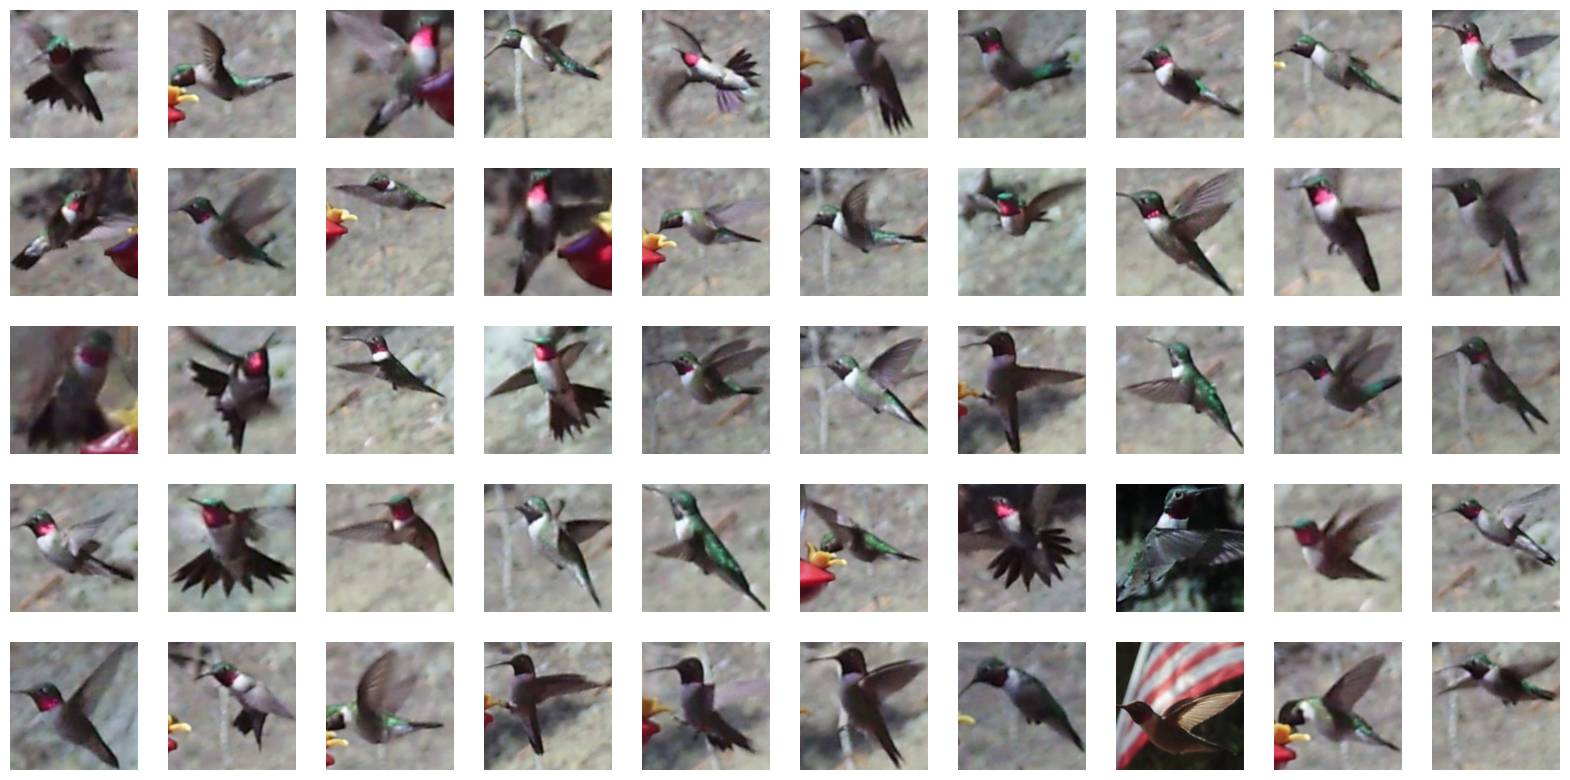

In [12]:
show_grid(lst_broad_male,5,10,figsize=(20,10))

#### **<span style='color:#B6DA32'>NO BIRD</span>**
- Given the amount of background noise/clutter (non bird pixels) we have in our images, <b>no_bird images seem like significant additions</b>.
- Especially important are the <b>flag</b> & <b>feeder</b> images which we saw in the background of some of the hummingbird images.
- The subset is quite self explanatory, no birds are present in any of the images, showing the environment around the feeder.

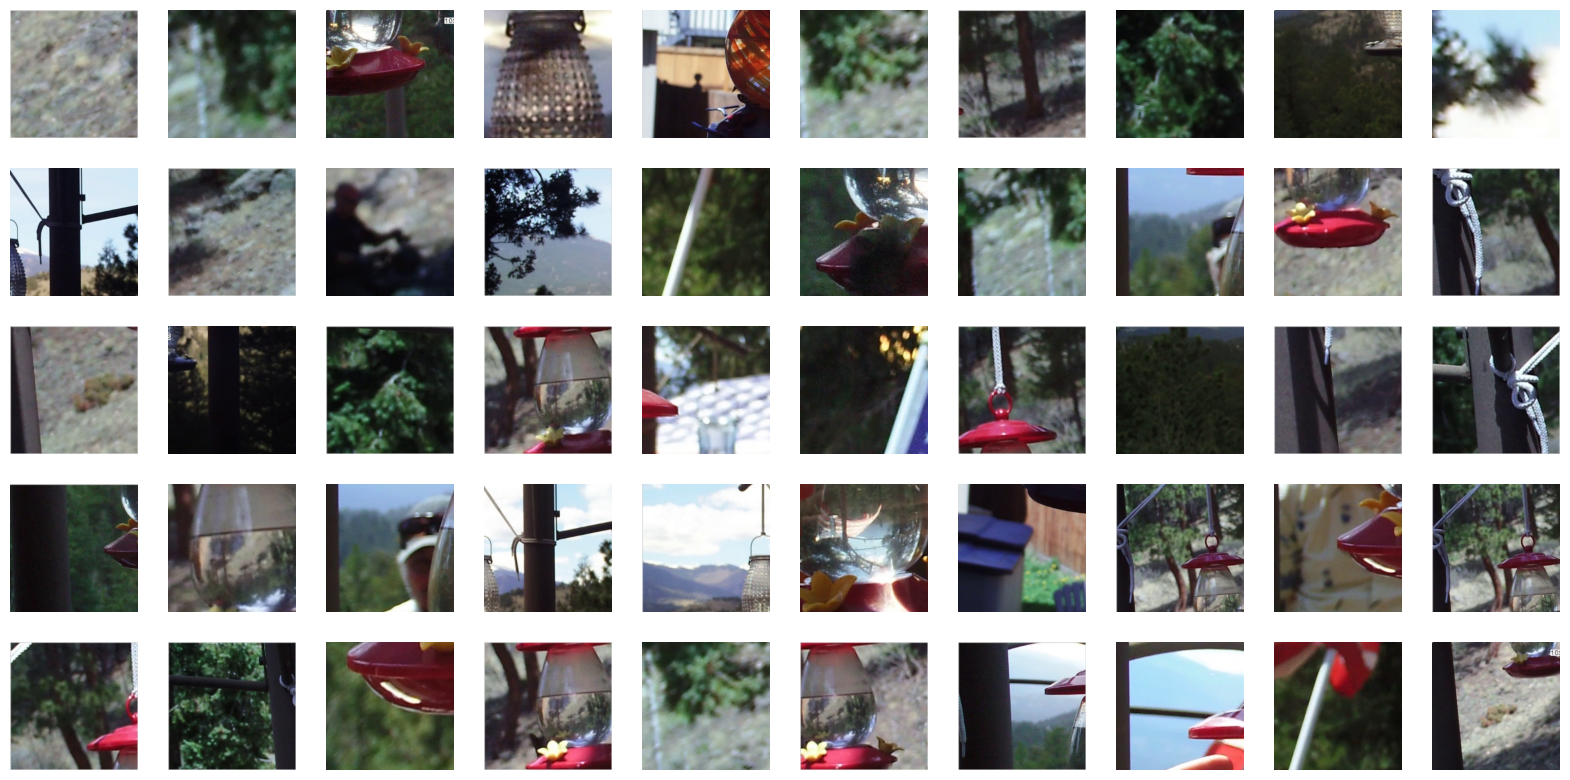

In [13]:
show_grid(lst_none,5,10,figsize=(20,10))

#### **<span style='color:#B6DA32'>REVIEWING THE DATA</span>**
- In the context of bird monitoring, what I think this dataset outlines more than anything else is that you don't need to place cameras right next to the feeder, which for some species can be offputting & the images don't need to be of perfect quality in order to create a classifier that can identify hummingbird species accurately.
- Most hummingbirds are very similar in shape and are <b>mostly differentiable by their colours</b>, so one channel CNN input network would be less effective than a three channel network, and we have to rely on all colour channels to distinguish the species.
- Having gone through the images, we can see that the current dataset is quite a challenging one. A lot of other hummingbirds, especially male have very <b>identifiable feather colours</b>, however in this dataset, aside from the <b>broadtail male</b>, most hummingbirds <b>seem amost identical to the naked eye</b>, especially in images which are slightly underexposed. As a result, it would be of great benefit to create a model that can identify the specie as accurately as possible at any given feeder.
- The <b>model heavily relies on accurate initial training label data</b> in order to be able to accurately classify the current set of hummingbirds on unseed data, so it was assumed that the dataset labels are as accurate as possible.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>2.2 |</span></b> Model training data</b></p>
</div>

- The modelling dataset is not very big; 100 images per class for <b>training</b> & 20 images per class for <b>validation</b> and <b>test</b> evaluation, used during training and subsequently for inference.
- The <b>classes are also well balanced</b>, containing the same number of images per class, thus we don't need to alter the balance of samples of each class.

In [14]:
class_types = len(os.listdir(train_folder))
print('Number of classes for Classification: ',class_types)
class_names = os.listdir(train_folder)
print(f'The class names are {class_names}\n')

print('Training dataset:')
for i in class_names:
    print(i + ':' + str(len(os.listdir(train_folder+i))))

print('\nValidation dataset:')
for i in class_names:
    print(i + ':' + str(len(os.listdir(val_folder+i))))

print('\nTest dataset:')
for i in class_names:
    print(i + ':' + str(len(os.listdir(test_folder+i))))

Number of classes for Classification:  4
The class names are ['No_bird', 'Broadtailed_female', 'Broadtailed_male', 'Rufous_female']

Training dataset:
No_bird:100
Broadtailed_female:100
Broadtailed_male:100
Rufous_female:100

Validation dataset:
No_bird:20
Broadtailed_female:20
Broadtailed_male:20
Rufous_female:20

Test dataset:
No_bird:20
Broadtailed_female:20
Broadtailed_male:20
Rufous_female:20


# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>3 |</span></b> Baseline CNN model</div>

- Firstly, we will create a <b>baseline model</b>, which we will use as a reference.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>3.1 |</span></b> Image Augmentation & Dataset Generation</b></p>
</div>

- One of the important factors affecting the accuracy of the CNN; <b>image augmentation</b>. We will focus our attention to the influence of augmentation quite a bit in this notebook.
- <b>Let's start off with a baseline</b>; With a preset <b>rescale</b> image augmentation, applied to both training data, validation & test data. ie. Making sure the values lie between [0,1]; which has proven to be quite important for neural netoworks to perform well.
- Upon defining the desired augmentation modification we will apply to the dataset, we can use the <b>flow_from_directory</b> data generator function to generate the dataset, as we already have our dataset nicely assembled into folders <b>train</b>,<b>valid</b> & <b>test</b>.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define DataGenerators
train_datagen = ImageDataGenerator(rescale=1.0/255)
gen_datagen = ImageDataGenerator(rescale=1.0/255)

In [16]:
# DataGenerators via Folder Directory
gen_train = train_datagen.flow_from_directory(
    train_folder,
    target_size=(cfg.sshape[0], cfg.sshape[1]),  # Menggunakan cfg.sshape sebagai ukuran target
    batch_size=32,
    class_mode='categorical'
)

gen_valid = gen_datagen.flow_from_directory(
    val_folder,
    target_size=(cfg.sshape[0], cfg.sshape[1]),  # Menggunakan cfg.sshape sebagai ukuran target
    batch_size=32,
    class_mode='categorical'
)

gen_test = gen_datagen.flow_from_directory(
    test_folder,
    target_size=(cfg.sshape[0], cfg.sshape[1]),  # Menggunakan cfg.sshape sebagai ukuran target
    batch_size=32,
    class_mode='categorical'
)


Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>3.2 |</span></b> Training a convolution neural network</b></p>
</div>

- Let's be sure to try out a less complicated neural network consisting of <b>two convolution layers</b>, <b>a pooling layer</b> and <b>dense block of layers</b> at first, and work out way upto more complex networks.
- The Neural network will have to be trained from scratch, with <b>randomly generated weights for initialisation</b>.
- To train a model, we need to first define a <b>model architecture</b>, then <b>compile</b> (req. <b>an optimiser</b>, <b>a loss function</b> & <b>evaluation metric</b>) it & subsequently <b>fit</b>, to train the model.
- <b>callbacks</b> are useful as well to control various aspect of the training procedure; lets use two commonly used ones <b>ReduceLROnPlateau</b> (for learning rate adjustment) & <b>ModelCheckpoint</b> (for model saves).
- Let's also plot common metrics used in classification: accuracy, f1, precision & recall.

#### **<span style='color:#B6DA32'>DEFINING THE EVALUATION METRICS</span>**
- By default, keras doesn't offer monitoring of <b>F1</b>,<b>precision</b> & <b>recall</b> during callbacks, but we can define our own, adding them to <code>model.compile</code>.

In [17]:
# Evaluation Metrics for Callback
def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### **<span style='color:#B6DA32'>DEFINING THE CNN MODEL</span>**
- We need to defined the **<span style='color:#B6DA32'>CNN architecture</span>** using <code>keras.models.Sequential</code>.
- We'll need **<span style='color:#B6DA32'>an optimiser</span>**, let's use the [Adam optimiser](https://keras.io/api/optimizers/)
- We need to define a **<span style='color:#B6DA32'>loss function</span>**; we'll use [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function)

In [18]:
# Two Convolution Layer CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3,
                            padding="same",
                            activation="relu",
                            input_shape=cfg.sshape),
    keras.layers.Conv2D(64, kernel_size=3,
                            padding="same",
                            activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(cfg.labels, activation="softmax")
])

# Show the Model Architecture
model.summary()

''' Model Compilation '''
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc',get_f1,get_precision,get_recall])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dropout (Dropout)           (None, 160000)            0         
                                                                 
 dense (Dense)               (None, 128)               20480128  
                                                        

#### **<span style='color:#B6DA32'>DEFINING THE CALLBACKS</span>**
**<span style='color:#B6DA32'>Callbacks</span>** will be used to monitor the progress of our model:
- We'll be using the <code>ReduceLROnPlateau</code> callback & stop model training once the model performance starts to stall as we don't want the model to overfit.
- We'll be saving our best performing model based on the <b>accuracy</b> metric using <code>ModelCheckpoint</code>.
- <code>TqdmCallback(verbose=0)</code> is very useful for reducing the keras iterative outputs to a few lines in each cell.

#### **<span style='color:#B6DA32'>TRAINING OUR MODEL</span>**
- Having defined the <b>architecture</b> & <b>compiled</b> our model, we can start to train the model.

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import time

# Definisikan callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, mode='max', min_lr=0.001),
    ModelCheckpoint(filepath='model_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
]

# Mulai Pelatihan
start = time.time()
for epoch in range(cfg.n_epochs):
    print(f"Epoch {epoch+1}/{cfg.n_epochs}")
    history = model.fit(
        gen_train,
        validation_data=gen_valid,  # Jika Anda juga memiliki generator validasi
        callbacks=callbacks,
        verbose=1
    )
end = time.time()

# Cetak waktu yang diperlukan untuk pelatihan
print(f'The time taken to execute is {round(end-start,2)} seconds.')


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.5842 - acc: 0.2750 - get_f1: 0.1282 - get_precision: 0.2644 - get_recall: 0.1106
Epoch 1: val_acc improved from -inf to 0.25000, saving model to model_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 9s 163ms/step - loss: 2.5842 - acc: 0.2750 - get_f1: 0.1282 - get_precision: 0.2644 - get_recall: 0.1106 - val_loss: 1.3349 - val_acc: 0.2500 - val_get_f1: 0.0986 - val_get_precision: 1.0000 - val_get_recall: 0.0521 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.2119 - acc: 0.4175 - get_f1: 0.2914 - get_precision: 0.7865 - get_recall: 0.1803
Epoch 1: val_acc improved from 0.25000 to 0.51250, saving model to model_cnn.h5
13/13 [==============================] - 1s 105ms/step - loss: 1.2119 - acc: 0.4175 - get_f1: 0.2914 - get_precision: 0.7865 - get_recall: 0.1803 - val_loss: 1.1783 - val_acc: 0.5125 - val_get_f1: 0.1652 - val_get_precision: 0.7000 - val_get_recall: 0.0938 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.9836 - acc: 0.6350 - get_f1: 0.4308 - get_precision: 0.8134 - get_recall: 0.3173
Epoch 1: val_acc improved from 0.51250 to 0.60000, saving model to model_cnn.h

In [20]:
''' FUNCTIONS FOR PLOTTING KERAS HISTORY RESULTS '''

# Function to plot all metrics side by side (defined above)
def plot_keras_metric(history):

    # Palettes
    lst_color = ['#B1D784', '#2E8486', '#004379', '#032B52', '#EAEA8A']
    metric_id = ['loss', 'get_f1', 'acc', 'get_precision', 'get_recall']

    fig = make_subplots(rows=1, cols=len(metric_id), subplot_titles=metric_id)

    jj = 0;

    for metric in metric_id:
        jj += 1

        # Main Trace
        fig.add_trace(go.Scatter(x=[i for i in range(1, cfg.n_epochs + 1)],
                                 y=history.history[metric],
                                 name=f'train_{metric}',
                                 line=dict(color=lst_color[0]), mode='lines'),
                      row=1, col=jj)
        fig.add_trace(go.Scatter(x=[i for i in range(1, cfg.n_epochs + 1)],
                                 y=history.history['val_' + metric],
                                 name=f'valid_{metric}',
                                 line=dict(color=lst_color[3]), mode='lines'),
                      row=1, col=jj)

        # difference between training/validation metrics
        if metric != 'loss':
            diff = abs(np.array(history.history[metric]) - np.array(history.history['val_' + metric]))
            fig.add_trace(go.Bar(x=[i for i in range(1, cfg.n_epochs + 1)], y=diff, name='metric diff.',
                                 text=diff.round(3), marker_color=lst_color[3], opacity=0.25, showlegend=False)
                          , row=1, col=jj)

    fig.update_layout(yaxis=dict(range=[0, 1]), yaxis_range=[0, 1],
                      margin=dict(t=60, b=10),
                      height=300, showlegend=False, template='plotly_white',
                      hovermode="x", title=f'<b>CNN TRAINING</b>')
    fig['layout']['yaxis'].update(title='', range=[0, 5], autorange=True, type='log')
    fig['layout']['yaxis2'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis3'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis4'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis5'].update(title='', range=[0, 1.1], autorange=False)

    fig.show()

In [21]:
plot_keras_metric(history)

#### **<span style='color:#B6DA32'>REVIEWING RESULTS</span>**
- What we can see is a neural network steadily learning & reaching a <b>validation accuracy</b> peak of about 0.85, which isn't too bad, both precision and recall are quite high.
- We are <b>not applying any augmentations other than scaling</b>, so it is unlikely the model will improve past this point, we defitely can see the validation loss stagnating a little.
- Next, we ought to test other augmentation additions, applied to the training of the same network.

# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>4 |</span></b> Augmentation influence CNN model</div>

#### **<span style='color:#B6DA32'>DATASET VARIATION DURING TRAINING</span>**

- There various combinations of **<span style='color:#B6DA32'>image augmentations</span>** that we can try in order to attempt find a <b>balance between overfitting and generalisation</b>.
- **<span style='color:#B6DA32'>Image augmentations</span>** also allow us to replicate the effect of adding slightly modified images during training, thus resulting in osscilations during training.
- The full collection of augmentations can be found in the [Keras manual](https://keras.io/api/preprocessing/image/).

#### **<span style='color:#B6DA32'>AUGMENTATION OPTIONS</span>**

- The selection of augmentation is like a hyperparameter, which will affect our accuracy. We need to investigate the effects of image augmentation in order to understand how they influence the training of the model accuracy, some combinations will result in an improvement & others won't, so the evaluation metric is expected to oscillate quite a bit compared to the base model that we have already evaluated.
- In the next section, we will use a generalised function, <code>augment_model</code> and **cycle through various combinations of image augmentation** to be applied during training.
- The <b>augment_model</b> is simply a function with all steps required to train a model, with the exception of the augmentation settings, which need to be imported via a list (<b>lst_aug</b>).

In [22]:
def plot_keras_metric2(lst_history,names):

    # Palettes
    lst_color = ['#B1D784','#2E8486','#004379','#032B52','#EAEA8A']
    metric_id = ['get_f1','acc','get_precision','get_recall']

    ii=-1
    for i in range(len(lst_history)):

        ii+=1; history = lst_history[ii]
        fig = make_subplots(rows=1, cols=4,subplot_titles=metric_id); jj=0
        for metric in metric_id:

            jj+=1

            # Main Trace
            fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=history.history[metric],
                                     name=f'train_{metric}_{ii}',line=dict(color=lst_color[0]),mode='lines'),
                          row=1,col=jj)
            fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=history.history['val_'+metric],
                                     name=f'valid_{metric}_{ii}',line=dict(color=lst_color[3]),mode='lines'),
                          row=1,col=jj)

            # difference between training/validation metrics
            diff = abs(np.array(history.history[metric]) - np.array(history.history['val_'+metric]))
            fig.add_trace(go.Bar(x=[i for i in range(1,cfg.n_epochs+1)],y=diff,name='metric diff.',
                                 text=diff.round(3),marker_color=lst_color[2],opacity=0.25,showlegend=False)
                          ,row=1,col=jj)

            # Rest are for reference only
            for j in range(len(names)):
                if(j != ii):
                    lhistory = lst_history[j]
                    fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=lhistory.history[metric],
                                             name=f'train_{metric}_{j}',opacity=0.3,showlegend=False,
                                             line=dict(color='#D3D3D3'),mode='lines'),row=1, col=jj)
                    fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=lhistory.history['val_'+metric],
                                             name=f'val_{metric}_{j}',opacity=0.3,showlegend=False,
                                             line=dict(color='#D3D3D3'),mode='lines'),row=1, col=jj)

        if(len(names)>1):
            title=f"{' | '.join(str(x) for x in names[ii])}"
            if(type(names[0]) is not list):
                title= names[ii]
        else:
            title= f"{''.join(str(x) for x in names[ii])}"

        fig.update_yaxes(tickvals=[i for i in np.arange(0.0,1.0,0.1)])
        fig.update_layout(yaxis=dict(range=[0,1]),yaxis_range=[0,1],
                          template='plotly_white',font=dict(family='sans-serif',size=14),
                          title=title,height=300,showlegend=False,
                          margin=dict(t=60,b=10)
                         )

        fig['layout']['yaxis1'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis2'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis3'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis4'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)

        fig.add_hline(y=1.0,line_width=5)
        fig.show()

In [23]:
''' Evaluate CNN model w/ imported list of augmentation options '''
# augment_model inputs nested lists of augmentation options & evaluates

def augment_model(lst_aug):

    # Define DataGenerator, load image data from directory
    gen_train = lst_aug[0].flow_from_directory(train_folder,
                            target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                            batch_size=32,          # batch size
                            class_mode='categorical')    # batch size

    gen_valid = lst_aug[1].flow_from_directory(val_folder,
                            target_size=(cfg.sshape[0],cfg.sshape[1]),
                            batch_size=32,
                            class_mode='categorical')

    gen_test = lst_aug[1].flow_from_directory(test_folder,
                            target_size=(cfg.sshape[0],cfg.sshape[1]),
                            batch_size=32,
                            class_mode='categorical')

    # Define a CNN Model
    model = keras.models.Sequential([

        keras.layers.Conv2D(32, kernel_size=3,
                                padding="same",
                                activation="relu",
                                input_shape=cfg.sshape),
        keras.layers.Conv2D(64,
                            kernel_size=3,
                            padding="same",
                            activation="relu"),

        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(cfg.labels, activation="softmax")
    ])

    # Compile Model
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['acc',get_f1,get_precision,get_recall])

    # Callback Options During Training
    callbacks = [ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=0,
                                   factor=0.5,mode='max',min_lr=0.001),
                 ModelCheckpoint(filepath=f'model_out.h5',monitor='val_accuracy',
                                 mode = 'max',verbose=0,save_best_only=True),
                 TqdmCallback(verbose=0)]

    # Evaluate Model
    history = model.fit(gen_train,
                        validation_data = gen_valid,
                        callbacks=callbacks,
                        verbose=0,epochs=cfg.n_epochs)

    # Return Result History
    return history

#### **<span style='color:#B6DA32'>VARIATION DURING TRAINING</span>**

- During each epoch, **a randomised combination of augmentation applied to each image** may lead to a spontaneous improvement in model accuracy.
- Aside from the perhaps adjustment of <b>brightness_range</b>, its not entirely clear what can potentially improve the model, so let's look at a few examples.
- What we are interesting in determining: <b>which particular combination of augmentation gives us the most promising improvement in metric performance.</b>
- Once we have this information, we can go ahead and try this augmentation on more sophisticated models, so we can potentially obtain a more accurate model.
- We'll loop through different augmentation combinations and save results in a list format.

In [24]:
# lst of augmentation options
lst_augopt = ['rescale','horizontal_flip','vertical_flip',
              'brightness_range','rotation_range','shear_range',
              'zoom_range','width_shift_range','height_shift_range',
              'channel_shift_range','zca_whitening','featurewise_center',
              'samplewise_center','featurewise_std_normalization','samplewise_std_normalization']

# lst of default setting corresponding to lst_augopt
lst_augval = [1.0/255,True,True,
              [1.1,1.5],0.2,0.2,
              0.2,0,0,
              0,True,False,
             False,False,False]

# Get Augmentation Names from lst_select options
def get_aug_name(lst_select):
    lst_selectn = [];
    for i in lst_select:
        tlst_all = []
        for j in i:
            tlist_selectn = tlst_all.append(lst_augopt[j])
        lst_selectn.append(tlst_all)
    return lst_selectn

# Model Evaluation w/ Augmentation
def aug_eval(lst_select=None):

    ii=-1; lst_history = []
    for augs in lst_select:

        print('Augmentation Combination')
        # get dictionary of augmentation options
        ii+=1; dic_select = dict(zip([lst_augopt[i] for i in lst_select[ii]],[lst_augval[i] for i in lst_select[ii]]))
        print(dic_select)

        # define augmentation options
        train_datagen = ImageDataGenerator(**dic_select) # pass arguments
        gen_datagen = ImageDataGenerator(rescale=1.0/255)

        # evaluate model & return history metric
        history = augment_model([train_datagen,gen_datagen])

        # store results
        lst_history.append(history)

    return lst_history

#### **<span style='color:#B6DA32'>TESTED AUGMENTATION COMBINATIONS</span>**

- <b>Combination 1</b> : <code>rescale (1/255)</code>, <code>horizontal_flip</code>
- <b>Combination 2</b> : <code>rescale (1/255)</code>, <code>vertical_flip</code>
- <b>Combination 3</b> : <code>rescale (1/255)</code>, <code>brightness_range (+1.1,+1.5)</code>
- <b>Combination 4</b> : <code>rescale (1/255)</code>, <code>horizontal_flip</code>, <code>shear_range (0.2)</code>, <code>zoom_range (0.2)</code>

In [25]:
# Select Augmentation
lst_select = [[0,1],[0,2],[0,3],[0,1,5,6]] # list of augmentations
lst_selectn = get_aug_name(lst_select)     # get list of augmentation names
print(lst_selectn)

[['rescale', 'horizontal_flip'], ['rescale', 'vertical_flip'], ['rescale', 'brightness_range'], ['rescale', 'horizontal_flip', 'shear_range', 'zoom_range']]


In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import time

# Definisikan callbacks
callbacks = [
      ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, mode='max', min_lr=0.001),
    ModelCheckpoint(filepath='model_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True, save_format='tf'),
]

# Mulai Pelatihan
start = time.time()
for epoch in range(cfg.n_epochs):
    print(f"Epoch {epoch+1}/{cfg.n_epochs}")
    history = model.fit(
        gen_train,
        validation_data=gen_valid,
        callbacks=callbacks,
        verbose=1
    )
end = time.time()

# Cetak waktu yang diperlukan untuk pelatihan
print(f'The time taken to execute is {round(end-start,2)} seconds.')


Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0011 - acc: 1.0000 - get_f1: 1.0000 - get_precision: 1.0000 - get_recall: 1.0000
Epoch 1: val_acc improved from -inf to 0.72500, saving model to model_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



13/13 [==============================] - 1s 108ms/step - loss: 0.0012 - acc: 1.0000 - get_f1: 1.0000 - get_precision: 1.0000 - get_recall: 1.0000 - val_loss: 1.6005 - val_acc: 0.7250 - val_get_f1: 0.7330 - val_get_precision: 0.7369 - val_get_recall: 0.7292 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 6.3166e-04 - acc: 1.0000 - get_f1: 1.0000 - get_precision: 1.0000 - get_recall: 1.0000
Epoch 1: val_acc did not improve from 0.72500
13/13 [==============================] - 1s 45ms/step - loss: 6.3166e-04 - acc: 1.0000 - get_f1: 1.0000 - get_precision: 1.0000 - get_recall: 1.0000 - val_loss: 1.5451 - val_acc: 0.7125 - val_get_f1: 0.7230 - val_get_precision: 0.7275 - val_get_recall: 0.7188 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.0018 - acc: 1.0000 - get_f1: 1.0000 - get_precision: 1.0000 - get_recall: 1.0000
Epoch 1: val_acc did not improve from 0.72500
13/13 [==============================] - 1s 47ms/step - los

In [27]:
# Langkah 1: Membuat riwayat pelatihan
lst_history = aug_eval(lst_select)

# Langkah 2: Memanggil fungsi plot_keras_metric2
plot_keras_metric2(lst_history, names=lst_selectn)


Augmentation Combination
{'rescale': 0.00392156862745098, 'horizontal_flip': True}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'vertical_flip': True}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'brightness_range': [1.1, 1.5]}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'horizontal_flip': True, 'shear_range': 0.2, 'zoom_range': 0.2}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

#### **<span style='color:#B6DA32'>REVIEWING RESULTS</span>**

#### **POSITIVE INFLUENCE OF BRIGHTNESS AUGMENTAION**

- It was thought that <b>due to the low brightness nature of a lot of images</b>, an increase in brightness would allow the model to more easily distinguish between different classes.
- We can see that when just by the applying the increased brightness augmentation (<b>Combination 3</b>); [0,3]  set to (+1.1,+1.5), the model outperforms all other variations within the first 5 iterations, both on <b>training</b> & <b>validation</b> dataasets, after which the validation accuracy starts to stagnate, and the model starts to show signs of overfitting.

#### **OTHER OBSERVATIONS**

- What was interesting to observe was the <b>balance between training/validation accuracies</b>.
- Models with lots of augmentation combinations (<b>Combination 4</b>) tended to learned slower, ended up with lower training accuracies but generalised better on unseen data.
- Simple Horizontal flipping, [0,1] (<b>Combination 1</b>) and the combination of four augmentations (shearing,zooming,flipping) [0,1,5,6], both were more effective than simply applying a brightness augmentation adjustments [0,3].

#### **USING FUNCTIONS**

- Due to the large number of possible augmentation combinations, it was quite convenient to create and test a <b>list based augmentation selection approach</b>.
- This allowed us to simple loop through the various set options.
- More testing would be quite interesting to try, however we should next <b>shift our attention to more sophisticated neural networks</b>, since they are more than likely going to allow us to edge the current validaiton accuracy score of our simple network.

# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>5 |</span></b> Transfer learning CNN models</div>

- Having a wide range of networks available to use, let's investigate various networks and their effects on the accuracy of the overall model.
- Aside from our own simple convolution network, let's look into established networks; <b>VGG</b>,<b>ResNet</b>,<b>MobileNet</b>,<b>Inception</b> & <b>EfficientNet</b>
- If we use established networks, we need to adjust the network, ie. adjust the tailend of the model, so it can be used in this problem.
- Head weights will be frozen so that the network doesn't overfit the training data.
- Having looked at different augmentations, let's use one of the better combinations & define the dataloaders again. It's not a given that augmentations that led to a better result using the simpler model will translate to a more complex, so let's investigate.

In [33]:
from sklearn.model_selection import train_test_split

# Splitting dataset into train and test/validation
train_files, test_files = train_test_split(train_folder, test_size=0.2, random_state=42)
train_files, valid_files = train_test_split(train_folder, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Using the best augmentation combination
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )
gen_datagen = ImageDataGenerator(rescale=1.0/255)

gen_train = train_datagen.flow_from_directory(train_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                        batch_size=32,          # batch size
                        class_mode='categorical')    # batch size

gen_valid = gen_datagen.flow_from_directory(val_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),
                        batch_size=32,
                        class_mode='categorical')

gen_test = gen_datagen.flow_from_directory(test_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),
                        batch_size=32,
                        class_mode='categorical')


Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [34]:
# from tensorflow.keras import applications as app
def pretrained_model(head_id):

    # Define model with different applications
    model = Sequential()

    ''' Define Head Pretrained Models '''

    if(head_id == 'vgg'):
        model.add(app.VGG16(input_shape=cfg.sshape,
                            pooling='avg',
                            classes=1000,
                            include_top=False,
                            weights='imagenet'))

    elif(head_id == 'resnet'):
        model.add(app.ResNet101(include_top=False,
                               input_tensor=None,
                               input_shape=cfg.sshape,
                               pooling='avg',
                               classes=100,
                               weights='imagenet'))

    elif(head_id == 'mobilenet'):
        model.add(app.MobileNet(alpha=1.0,
                               depth_multiplier=1,
                               dropout=0.001,
                               include_top=False,
                               weights="imagenet",
                               input_tensor=None,
                               input_shape = cfg.sshape,
                               pooling=None,
                               classes=1000))

    elif(head_id == 'inception'):
        model.add(InceptionV3(input_shape = cfg.sshape,
                                 include_top = False,
                                 weights = 'imagenet'))

    elif(head_id == 'efficientnet'):
        model.add(EfficientNetB4(input_shape = cfg.sshape,
                                    include_top = False,
                                    weights = 'imagenet'))

    ''' Tail Model Part '''
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(cfg.labels,activation='softmax'))

    # # freeze main model coefficients
    model.layers[0].trainable = False
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['acc',get_f1,get_precision,get_recall])

    return model # return compiled model

In [35]:
# Pretraine Loaded Model
def pretrain_eval(lst_heads,verbose=False):

    lst_history = []
    for head_id in lst_heads:

        # define CNN head model
        model = pretrained_model(head_id)

        ''' Callback Options During Training '''
        callbacks = [ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=0,
                                       factor=0.5,mode='max',min_lr=0.002),
                     ModelCheckpoint(filepath=f'model_{head_id}.h5',monitor='val_acc',
                                     mode = 'max',verbose=0,save_best_only=True),
                     TqdmCallback(verbose=0)]

        ''' Start Training '''
        start = time.time()
        history = model.fit(gen_train,
                            validation_data = gen_valid,
                            callbacks=callbacks,
                            verbose=0,
                            epochs=cfg.n_epochs)
        end = time.time()
        if(verbose):
            print(f'Head Model: {head_id}')
            print(f'The time taken to execute is {round(end-start,2)} seconds.')
            print(f'Maximum Train/Val {max(history.history["acc"]):.4f}/{max(history.history["val_acc"]):.4f}')

        lst_history.append(history)

    return lst_history

In [36]:
''' Define Model Architectre '''
lst_heads = ['vgg','resnet','mobilenet','inception','efficientnet']
history = pretrain_eval(lst_heads)

58889256/58889256 [==============================] - 2s 0us/step


0epoch [00:00, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



171446536/171446536 [==============================] - 4s 0us/step


0epoch [00:00, ?epoch/s]

17225924/17225924 [==============================] - 1s 0us/step


0epoch [00:00, ?epoch/s]

87910968/87910968 [==============================] - 3s 0us/step


0epoch [00:00, ?epoch/s]

71686520/71686520 [==============================] - 3s 0us/step


0epoch [00:00, ?epoch/s]

In [37]:
plot_keras_metric2(history,names=lst_heads)

#### **<span style='color:#B6DA32'>REVIEWING RESULTS</span>**
- Pretrained models are built in a way that allows us to load and modify the tail end of the model to fit our own number of label case.
- A simplistic tail end dense layer was added, however it most likely is not optimal, and neither are the predefined settings for each class, nevertheless it was interesting to compare the different models to one another and compare their performance.
- <b>VGG</b>, <b>InceptionV3</b> and most notably <b>MobileNet</b> were among the best performing models. In this case, we can see that model performance for both training and test showed a high nature of correlation, <b>MobileNet</b> was able to reach a validation accuracy of 0.975. Due to the large nature of customisability in such problems, it's quite likely that further improvement is possible given the right combination of augmentations are applied.

# <div style="padding: 30px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#B6DA32;overflow:hidden"><b><span style='color:white'>6 |</span></b> Inference</div>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B6DA32'>6.1 |</span></b> Unseen test images</b></p>
</div>

- We want to test our models on unseed data, so we'll be using the previously defined <code>gen_test</code> data.
- We'll be using the transfer learning models that that were defined in the previous section as they were the higher performing models.
- Having created a model & verified that our model has a <b>good balance between training & validation accuracy</b>, let's see how well the model performs on unseed data.

In [38]:
for head_id in lst_heads:
    print(f'Head Model: {head_id}')

    # Load uncompiled model
    load_model = models.load_model(f"model_{head_id}.h5",compile=False)

    # Compile model
    load_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['acc',get_f1,get_precision,get_recall])

    # Evaluate on test dataset
    scores = load_model.evaluate(gen_test, verbose=1)

Head Model: vgg
3/3 [==============================] - 1s 43ms/step - loss: 0.2383 - acc: 0.9250 - get_f1: 0.9160 - get_precision: 0.9261 - get_recall: 0.9062
Head Model: resnet
3/3 [==============================] - 3s 63ms/step - loss: 1.0321 - acc: 0.6125 - get_f1: 0.3618 - get_precision: 0.7528 - get_recall: 0.2396
Head Model: mobilenet
3/3 [==============================] - 1s 24ms/step - loss: 0.3618 - acc: 0.9000 - get_f1: 0.9062 - get_precision: 0.9062 - get_recall: 0.9062
Head Model: inception


3/3 [==============================] - 3s 35ms/step - loss: 0.5733 - acc: 0.8500 - get_f1: 0.8583 - get_precision: 0.8626 - get_recall: 0.8542
Head Model: efficientnet


3/3 [==============================] - 5s 57ms/step - loss: 7.5634 - acc: 0.2500 - get_f1: 0.2604 - get_precision: 0.2604 - get_recall: 0.2604
